In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
from astropy.io import fits

import json
from copy import deepcopy

In [3]:
import os
indir = '/Users/jarron/NIRCam/Data/cosmic_rays/'

allfits = [file for file in os.listdir(indir) if file.endswith('.fits')]
allfits = np.sort(allfits)

In [4]:
LWA_files = [file for file in allfits if file.endswith('A5.fits')]
LWB_files = [file for file in allfits if file.endswith('B5.fits')]
LW_files = LWA_files + LWB_files

SW_files = [file for file in allfits if not file.endswith('5.fits')]


# The different detector files duplicate each other 
# with regards to cosmic ray intensities and distributions.
# So, we only need to look at 1 series of detectors.
# Let's just go with A1

files = [file for file in allfits if file.endswith('A1.fits')]

In [5]:
cr_dict= {}

# Hit rates in events / cm^2 / sec
min_rate = np.array([4.4626, 0.4106, 0.0108, 0.0029, 0.0103, 0.0011])
max_rate = np.array([1.5782, 0.1882, 0.0051, 0.0014, 0.0048, 0.0006])
flare_rate = np.array([3033.4, 13.300, 0.0422, 0.0093, 0.0664, 0.0112])
rates_dict = {'SUNMIN': min_rate, 'SUNMAX': max_rate, 'FLARES': flare_rate}

for scenario in rates_dict.keys():
    ions_dict = {}
    ion = []
    mev = []
    counts = []
    for f in files:
        if scenario in f:
            hdul = fits.open(indir + f)
            ion.append(hdul[2].data)
            mev.append(hdul[3].data)
            counts.append(hdul[1].data.sum(axis=(1,2)))
            hdul.close()
            
    ion = np.array(ion).flatten()
    mev = np.array(mev).flatten()
    counts = np.array(counts).flatten()
    
    # Hit rates in events / cm^2 / sec
    rates = rates_dict[scenario]
    
    for i in np.unique(ion):
        ind = ion==i
        if ind.sum()>0:
            isort = np.argsort(mev[ind])
            ions_dict[str(i)] = {'mev': mev[ind][isort], 'counts': counts[ind][isort], 'rates': rates[i]}
            
    cr_dict[scenario] = ions_dict

(10.0, 10000000.0)

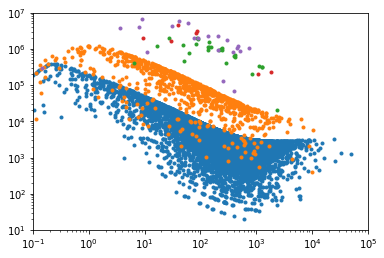

In [6]:
for i in range(5):
    plt.loglog(cr_dict['SUNMIN'][str(i)]['mev'], cr_dict['SUNMIN'][str(i)]['counts'], marker='.', ls='none')
    
plt.xlim([1e-1, 1e5])
plt.ylim([1e1, 1e7])

In [30]:
outname = 'cosmic_rays.json'

# Save to JSON file
# Make a deepcopy of dict to convert np.array to lists
dtemp = deepcopy(cr_dict_lw)
for k in dtemp.keys():
    if isinstance(dtemp[k], (np.ndarray)):
        dtemp[k] = dtemp[k].tolist()
        
    dtemp2 = dtemp[k]
    for k2 in dtemp2.keys():
        if isinstance(dtemp2[k2], (np.ndarray)):
            dtemp2[k2] = dtemp2[k2].tolist()

        dtemp3 = dtemp2[k2]
        for k3 in dtemp3.keys():
            if isinstance(dtemp3[k3], (np.ndarray)):
                dtemp3[k3] = dtemp3[k3].tolist()

            
with open(outname, 'w') as fp:
    json.dump(dtemp, fp, sort_keys=False, indent=4)

# Load JSON file

In [8]:
outname = 'cosmic_rays.json'

# Load from JSON file
with open(outname, 'r') as fp:
    cr_dict = json.load(fp)

# # Convert lists to np.array
# for k in cr_dict.keys():
#     if isinstance(cr_dict[k], (list)):
#         cr_dict[k] = np.asarray(cr_dict[k])
        
#     dtemp2 = cr_dict[k]
#     for k2 in dtemp2.keys():
#         if isinstance(dtemp2[k2], (list)):
#             dtemp2[k2] = np.asarray(dtemp2[k2])

#         dtemp3 = dtemp2[k2]
#         for k3 in dtemp3.keys():
#             if isinstance(dtemp3[k3], (list)):
#                 dtemp3[k3] = np.asarray(dtemp3[k3])


In [9]:
type_dict = cr_dict['SUNMIN']
ion_keys = type_dict.keys()

In [10]:
area_cm = 13.59
tgroup = 10.75
rng = np.random.default_rng()

k = list(ion_keys)[0]

rate   = type_dict[k]['rates'] # events / cm^2 / sec
# How many event per frame on average?
nhits = rate * area_cm * tgroup
nhits = rng.poisson(nhits)

# A number of random events
mev    = np.asarray(type_dict[k]['mev'])
counts = np.asarray(type_dict[k]['counts'])

# Do a random sample

%time res = rng.choice(counts, nhits)

CPU times: user 168 µs, sys: 38 µs, total: 206 µs
Wall time: 212 µs


In [11]:
data = np.ones([10,2048,2048]) * np.arange(1,11).reshape([-1,1,1])*100

In [14]:
from pynrc.simul.ngNRC import add_cosmic_rays
data = add_cosmic_rays(data, scenario='SUNMAX', tframe=10.73677, ref_info=[4,4,4,4])

In [18]:
iy, ix = np.argwhere(data[-1]==np.max(data[-1]))[0]

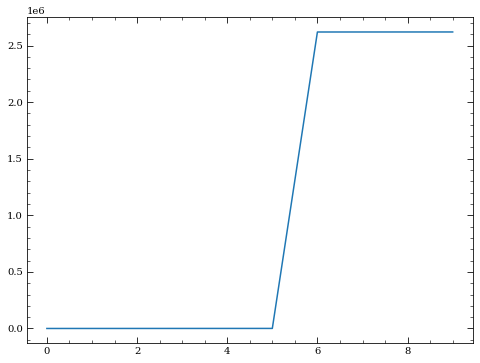

In [19]:
plt.plot(data[:, iy, ix])

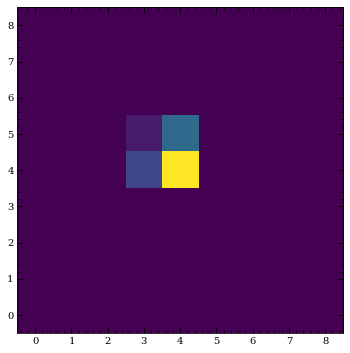

In [22]:
plt.imshow(data[-1,iy-4:iy+5,ix-4:ix+5])